In [6]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [7]:
import os
import shutil

# Define the source directories for the healthy and pneumonia images
healthy_dirs = [
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/test/NORMAL',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/train/NORMAL',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/val/NORMAL',
]

pneumonia_dirs = [
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/test/PNEUMONIA',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/train/PNEUMONIA',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/val/PNEUMONIA',
]

# Define the new directory to store the organized images
new_base_dir = r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset'

# Create the base directory if it doesn't exist
if not os.path.exists(new_base_dir):
    os.makedirs(new_base_dir)

# Create 'normal' and 'pneumonia' subfolders
normal_dir = os.path.join(new_base_dir, 'normal')
pneumonia_dir = os.path.join(new_base_dir, 'pneumonia')

os.makedirs(normal_dir, exist_ok=True)
os.makedirs(pneumonia_dir, exist_ok=True)

# Function to copy images from source directories to destination
def copy_images(src_dirs, dest_dir):
    for dir_path in src_dirs:
        for filename in os.listdir(dir_path):
            file_path = os.path.join(dir_path, filename)
            if os.path.isfile(file_path):
                shutil.copy(file_path, dest_dir)

# Copy images from healthy (normal) and pneumonia directories
copy_images(healthy_dirs, normal_dir)
copy_images(pneumonia_dirs, pneumonia_dir)

print("Images have been successfully copied to the new directory.")


Images have been successfully copied to the new directory.



Displaying Normal images info:
Image 1 - Size: (1317, 1857, 3) (Height x Width x Channels)
Image 2 - Size: (1509, 2111, 3) (Height x Width x Channels)
Image 3 - Size: (1837, 2031, 3) (Height x Width x Channels)


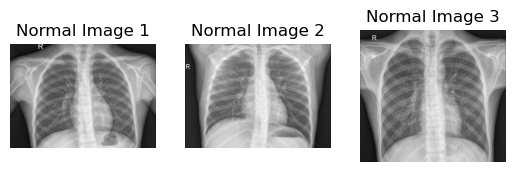


Displaying Pneumonia images info:
Image 1 - Size: (760, 1152, 3) (Height x Width x Channels)
Image 2 - Size: (768, 1072, 3) (Height x Width x Channels)
Image 3 - Size: (863, 1244, 3) (Height x Width x Channels)


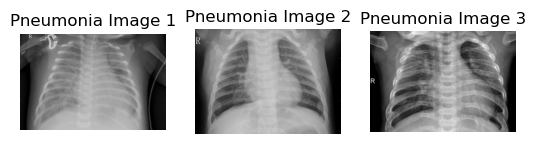

In [8]:
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir)]

# Display a few images from each class and print their size and channels
def display_image_info(images, class_name):
    print(f"\nDisplaying {class_name} images info:")
    for i, image_path in enumerate(images[:3]):  # Display the first 3 images
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f'{class_name} Image {i+1}')
        # Image details
        print(f"Image {i+1} - Size: {img.shape} (Height x Width x Channels)")
    
    plt.show()

# Display images and their details
display_image_info(normal_images, 'Normal')
display_image_info(pneumonia_images, 'Pneumonia')

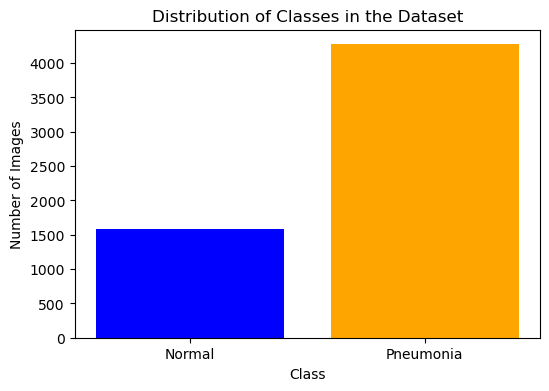


Class Distribution:
Normal: 1583 images
Pneumonia: 4273 images


In [9]:
# Plot the distribution of both classes
class_counts = {
    'Normal': len(normal_images),
    'Pneumonia': len(pneumonia_images),
}

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.title("Distribution of Classes in the Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Optional: Print class distribution
print("\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


In [10]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to perform data augmentation on the normal class
def augment_data(normal_images, normal_dir, augmentation_count=3000):
    # Initialize the ImageDataGenerator with common augmentations
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    augmented_count = 0

    # Loop through each image in the normal class
    for img_path in normal_images:
        # Load the image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Reshape the image to fit the model's expected input shape
        img_array = np.expand_dims(img_rgb, axis=0)
        
        # Generate augmented images
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=normal_dir, save_prefix='aug', save_format='jpeg'):
            augmented_count += 1
            if augmented_count >= augmentation_count:
                break

        if augmented_count >= augmentation_count:
            break
    
    print(f"Data augmentation complete")

# Augment the normal class images to balance the dataset
augment_data(normal_images, normal_dir, augmentation_count=3000)


Data augmentation complete


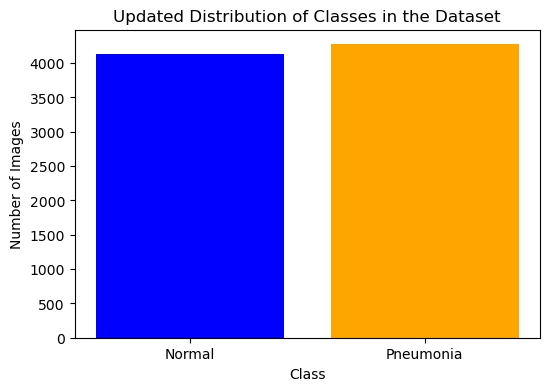


Updated Class Distribution:
Normal: 4138 images
Pneumonia: 4273 images


In [11]:
# List all images in normal and pneumonia directories
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, img))]
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir) if os.path.isfile(os.path.join(pneumonia_dir, img))]

# Updated class counts
class_counts = {
    'Normal': len(normal_images),
    'Pneumonia': len(pneumonia_images),
}

# Plot the updated class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.title("Updated Distribution of Classes in the Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Optional: Print updated class distribution
print("\nUpdated Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


In [13]:
import os
import pandas as pd

healthy_dirs = [r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal'] 

pneumonia_dir = [r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/pneumonia']

filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                                           filepaths  labels
0  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
1  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
2  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
3  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
4  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
labels
Pneumonia    4273
Normal       4138
Name: count, dtype: int64


In [14]:
pneumonia_df.shape


(8411, 2)

In [16]:
train_images, test_images = train_test_split(pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(pneumonia_df, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)


(6728, 2)
(2524, 2)
(1683, 2)


In [17]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 6728 validated image filenames belonging to 2 classes.
Found 2524 validated image filenames belonging to 2 classes.
Found 1683 validated image filenames belonging to 2 classes.


In [18]:
classes=list(train.class_indices.keys())
print (classes)

['Normal', 'Pneumonia']


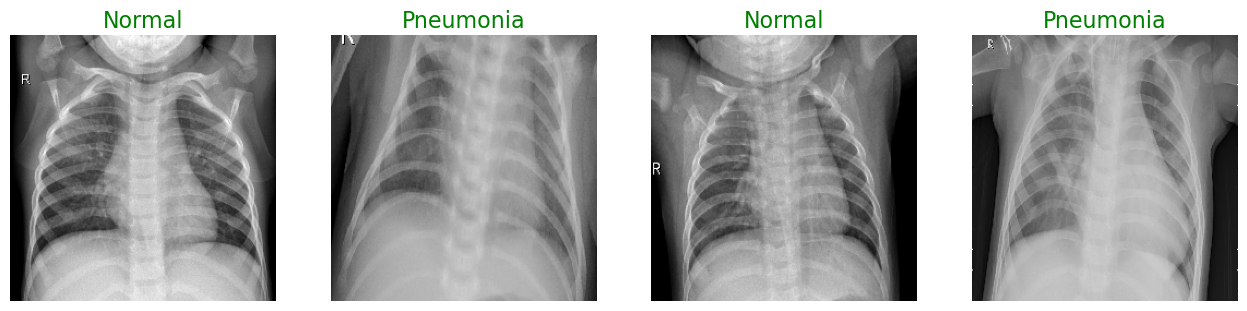

In [24]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)



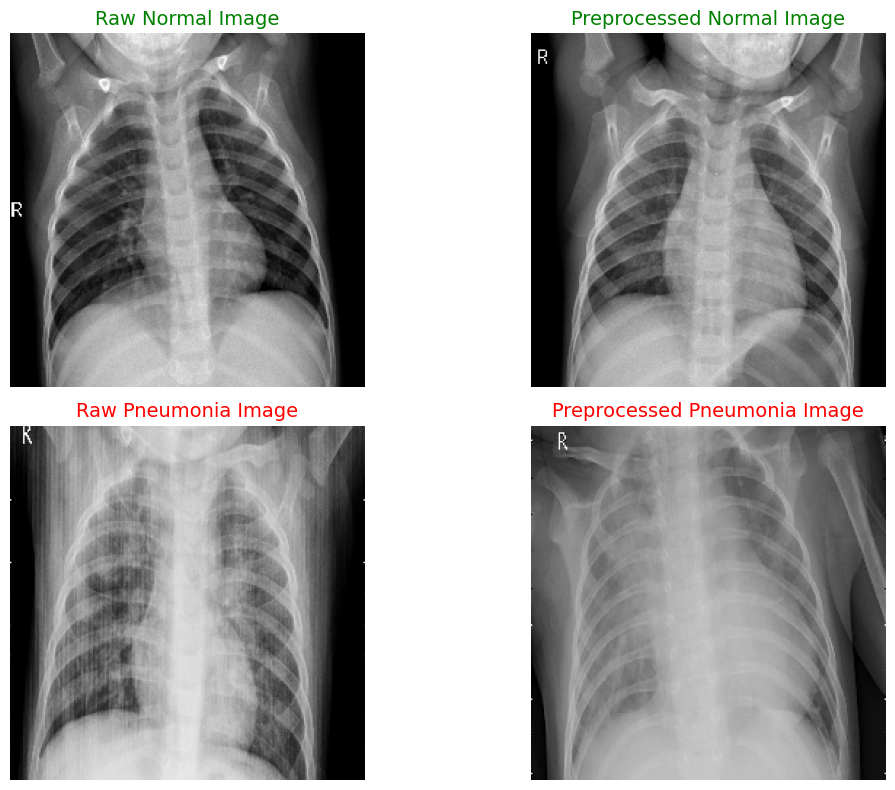

In [43]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def compare_raw_vs_preprocessed(normal_path, pneumonia_path, image_gen):
    """
    Compare one Normal and one Pneumonia image from raw paths with their preprocessed counterparts.
    
    Args:
        normal_path: Directory path containing NORMAL chest X-ray images.
        pneumonia_path: Directory path containing PNEUMONIA chest X-ray images.
        image_gen: ImageDataGenerator instance used for preprocessing.
    """
    # Select one random NORMAL and one PNEUMONIA image
    normal_file = random.choice(os.listdir(normal_path))
    pneumonia_file = random.choice(os.listdir(pneumonia_path))
    
    normal_raw_path = os.path.join(normal_path, normal_file)
    pneumonia_raw_path = os.path.join(pneumonia_path, pneumonia_file)
    
    # Load raw images
    normal_raw_img = img_to_array(load_img(normal_raw_path, target_size=(244, 244)))
    pneumonia_raw_img = img_to_array(load_img(pneumonia_raw_path, target_size=(244, 244)))
    
    # Get preprocessed images from the generator
    images, labels = next(image_gen)
    normal_preprocessed_img = (images[np.argmax(labels[:, 0])] + 1) / 2  # First NORMAL image
    pneumonia_preprocessed_img = (images[np.argmax(labels[:, 1])] + 1) / 2  # First PNEUMONIA image
    
    # Plot side-by-side comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Raw Normal Image
    axes[0, 0].imshow(normal_raw_img.astype(np.uint8))
    axes[0, 0].set_title("Raw Normal Image", fontsize=14, color="green")
    axes[0, 0].axis('off')
    
    # Preprocessed Normal Image
    axes[0, 1].imshow(normal_preprocessed_img)
    axes[0, 1].set_title("Preprocessed Normal Image", fontsize=14, color="green")
    axes[0, 1].axis('off')
    
    # Raw Pneumonia Image
    axes[1, 0].imshow(pneumonia_raw_img.astype(np.uint8))
    axes[1, 0].set_title("Raw Pneumonia Image", fontsize=14, color="red")
    axes[1, 0].axis('off')
    
    # Preprocessed Pneumonia Image
    axes[1, 1].imshow(pneumonia_preprocessed_img)
    axes[1, 1].set_title("Preprocessed Pneumonia Image", fontsize=14, color="red")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with NORMAL and PNEUMONIA directories and the ImageDataGenerator instance
compare_raw_vs_preprocessed(
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/train/NORMAL',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/train/PNEUMONIA',
    train
)


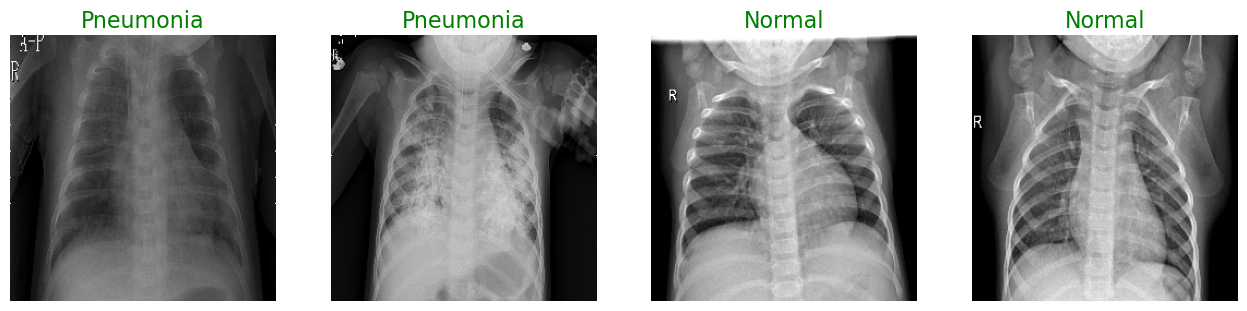

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


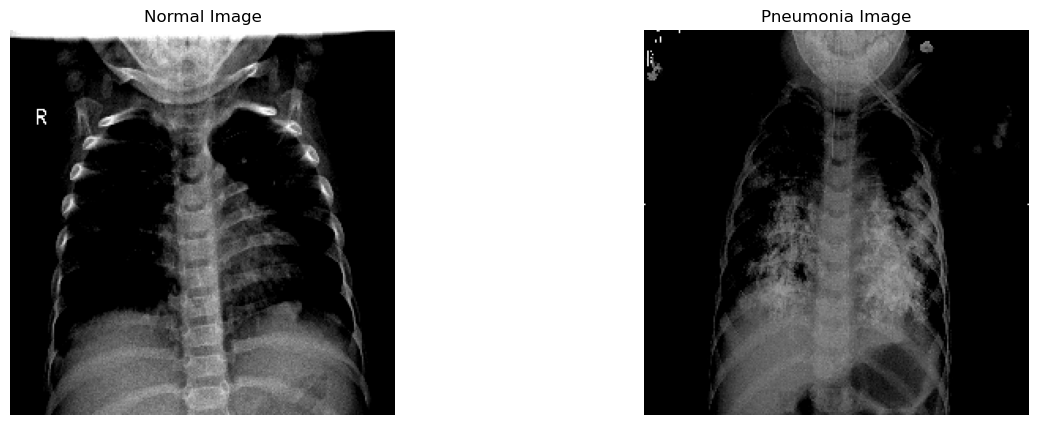

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


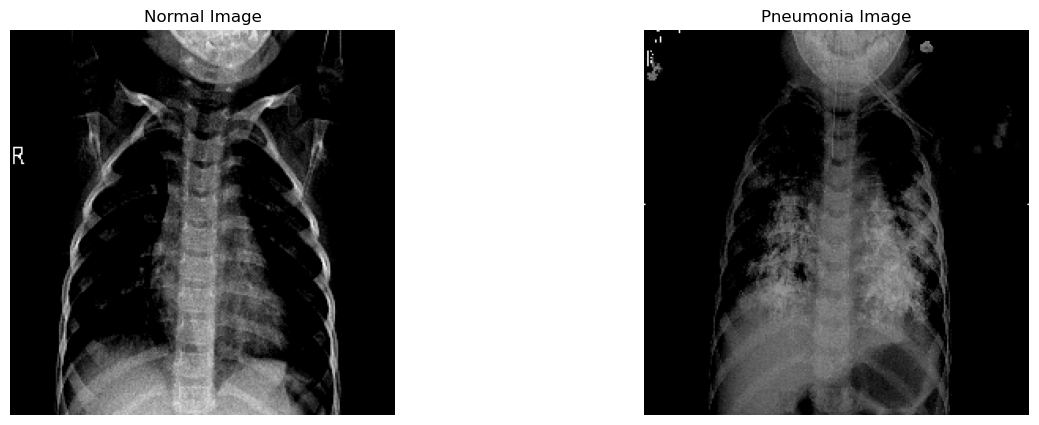

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # scale images between 0 and 1
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()

    # Now comparing normal vs pneumonia images
    for i in range(len(images)):
        # Load the image for visual comparison
        img = images[i]
        class_name = classes[np.argmax(labels[i])]
        
        if class_name == 'Normal':
            normal_img = img
        elif class_name == 'Pneumonia':
            pneumonia_img = img
        
        # If both normal and pneumonia images are found, display them
        if 'normal_img' in locals() and 'pneumonia_img' in locals():
            # Visualize the original normal and pneumonia images
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))
            ax[0].imshow(normal_img)
            ax[0].set_title("Normal Image")
            ax[0].axis('off')
            
            ax[1].imshow(pneumonia_img)
            ax[1].set_title("Pneumonia Image")
            ax[1].axis('off')
            
            plt.show()

    # Call the function again to display more images if needed
show_knee_images(train)


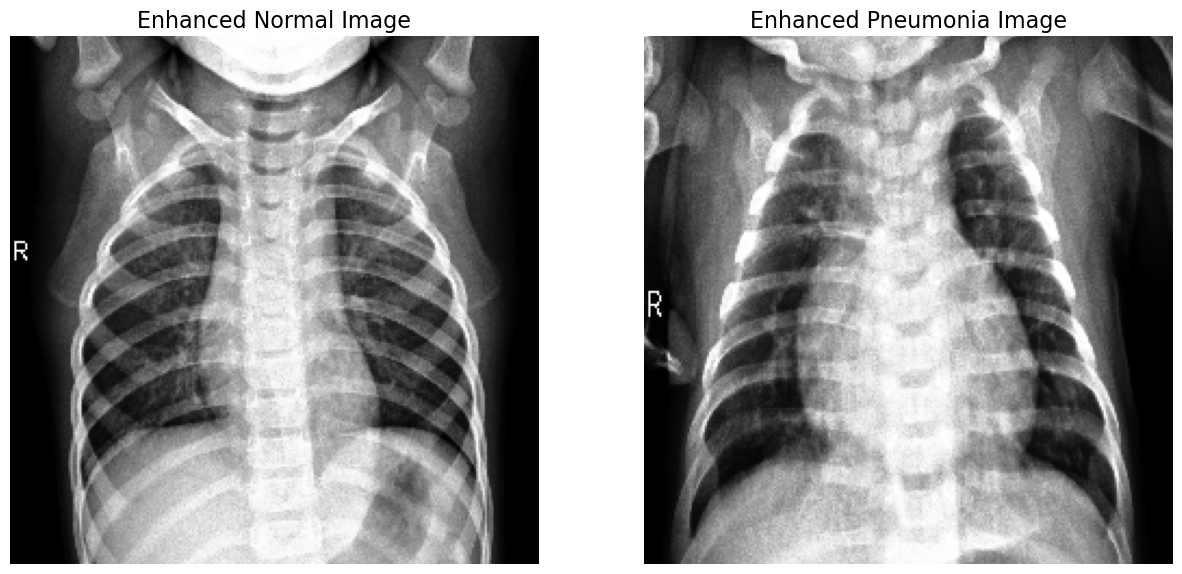

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)  # Get a sample batch from the generator

    # Get one normal and one pneumonia image
    normal_idx = np.argmax(labels, axis=1) == test_dict['Normal']
    pneumonia_idx = np.argmax(labels, axis=1) == test_dict['Pneumonia']

    # Get the first NORMAL and PNEUMONIA images from the batch
    normal_img = images[normal_idx][0]
    pneumonia_img = images[pneumonia_idx][0]

    # Normalize images to [0, 255] and convert to uint8 for better visualization
    normal_img = ((normal_img + 1) / 2 * 255).astype(np.uint8)  # Rescale to [0, 255]
    pneumonia_img = ((pneumonia_img + 1) / 2 * 255).astype(np.uint8)

    # Enhance contrast (Histogram Equalization)
    normal_img = cv2.equalizeHist(cv2.cvtColor(normal_img, cv2.COLOR_RGB2GRAY))
    pneumonia_img = cv2.equalizeHist(cv2.cvtColor(pneumonia_img, cv2.COLOR_RGB2GRAY))

    # Plot the two images
    plt.figure(figsize=(15, 10))

    # Normal Image
    plt.subplot(1, 2, 1)
    plt.imshow(normal_img, cmap='gray')  # Display in grayscale
    plt.title("Enhanced Normal Image", fontsize=16)
    plt.axis('off')

    # Pneumonia Image
    plt.subplot(1, 2, 2)
    plt.imshow(pneumonia_img, cmap='gray')  # Display in grayscale
    plt.title("Enhanced Pneumonia Image", fontsize=16)
    plt.axis('off')

    plt.show()

# Call the function
show_knee_images(train)


In [62]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,609,474 (59.55 MB)

 Trainable params: 15,603,074 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [64]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2362s 1s/step - accuracy: 0.8328 - loss: 0.5601 - val_accuracy: 0.9661 - val_loss: 0.0983
Epoch 2/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2231s 1s/step - accuracy: 0.9379 - loss: 0.1716 - val_accuracy: 0.9673 - val_loss: 0.0923
Epoch 3/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2236s 1s/step - accuracy: 0.9490 - loss: 0.1372 - val_accuracy: 0.9614 - val_loss: 0.1178
Epoch 4/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2096s 1s/step - accuracy: 0.9656 - loss: 0.0940 - val_accuracy: 0.9745 - val_loss: 0.0764
Epoch 5/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2244s 1s/step - accuracy: 0.9728 - loss: 0.0809 - val_accuracy: 0.9750 - val_loss: 0.0781
Epoch 6/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2493s 1s/step - accuracy: 0.9821 - loss: 0.0517 - val_accuracy: 0.9739 - val_loss: 0.0859
Epoch 7/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 2775s 2s/step - accuracy: 0.9818 - loss: 0.0454 - val_accuracy: 0.9649 - val_loss: 0.0975
Epoch 8/10
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 3194s 2s/step - accuracy: 0.9874 -

In [65]:
model.evaluate(test, verbose=1)

631/631 ━━━━━━━━━━━━━━━━━━━━ 208s 330ms/step - accuracy: 0.9746 - loss: 0.0922


[0.0881202295422554, 0.9766244292259216]

In [66]:
model.save("pneumonia_Model.h5")

In [67]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

631/631 ━━━━━━━━━━━━━━━━━━━━ 206s 325ms/step


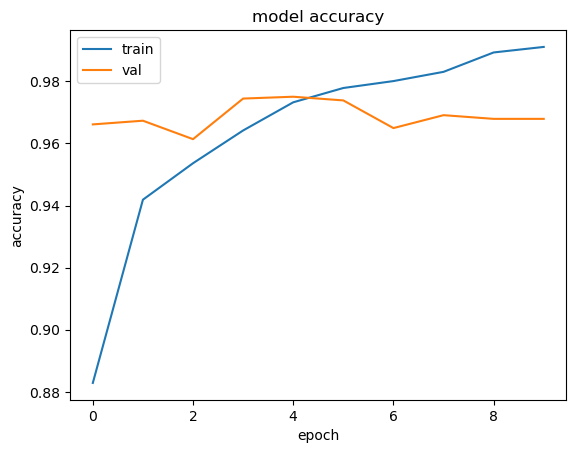

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

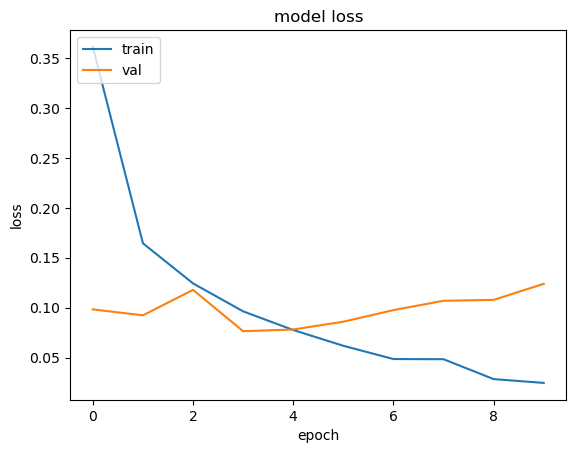

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.96      0.99      0.98      1240
   Pneumonia       0.99      0.96      0.98      1284

    accuracy                           0.98      2524
   macro avg       0.98      0.98      0.98      2524
weighted avg       0.98      0.98      0.98      2524

Accuracy of the Model: 97.7%


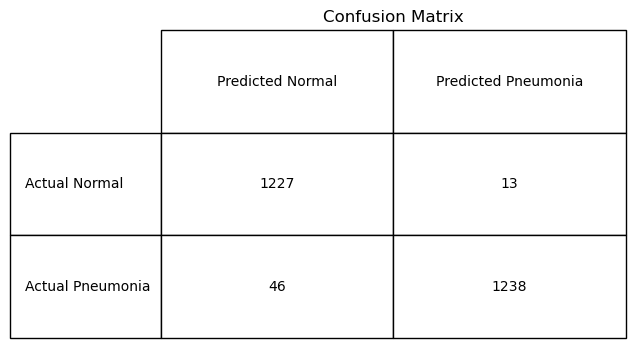

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, pred2)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=[f'Actual {label}' for label in class_labels], columns=[f'Predicted {label}' for label in class_labels])

# Display the confusion matrix as a table
plt.figure(figsize=(6, 4))
plt.table(cellText=cm_df.values, colLabels=cm_df.columns, rowLabels=cm_df.index, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0, 1, 1])

# Remove axes
plt.axis('off')

# Title
plt.title('Confusion Matrix')

# Show the table
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


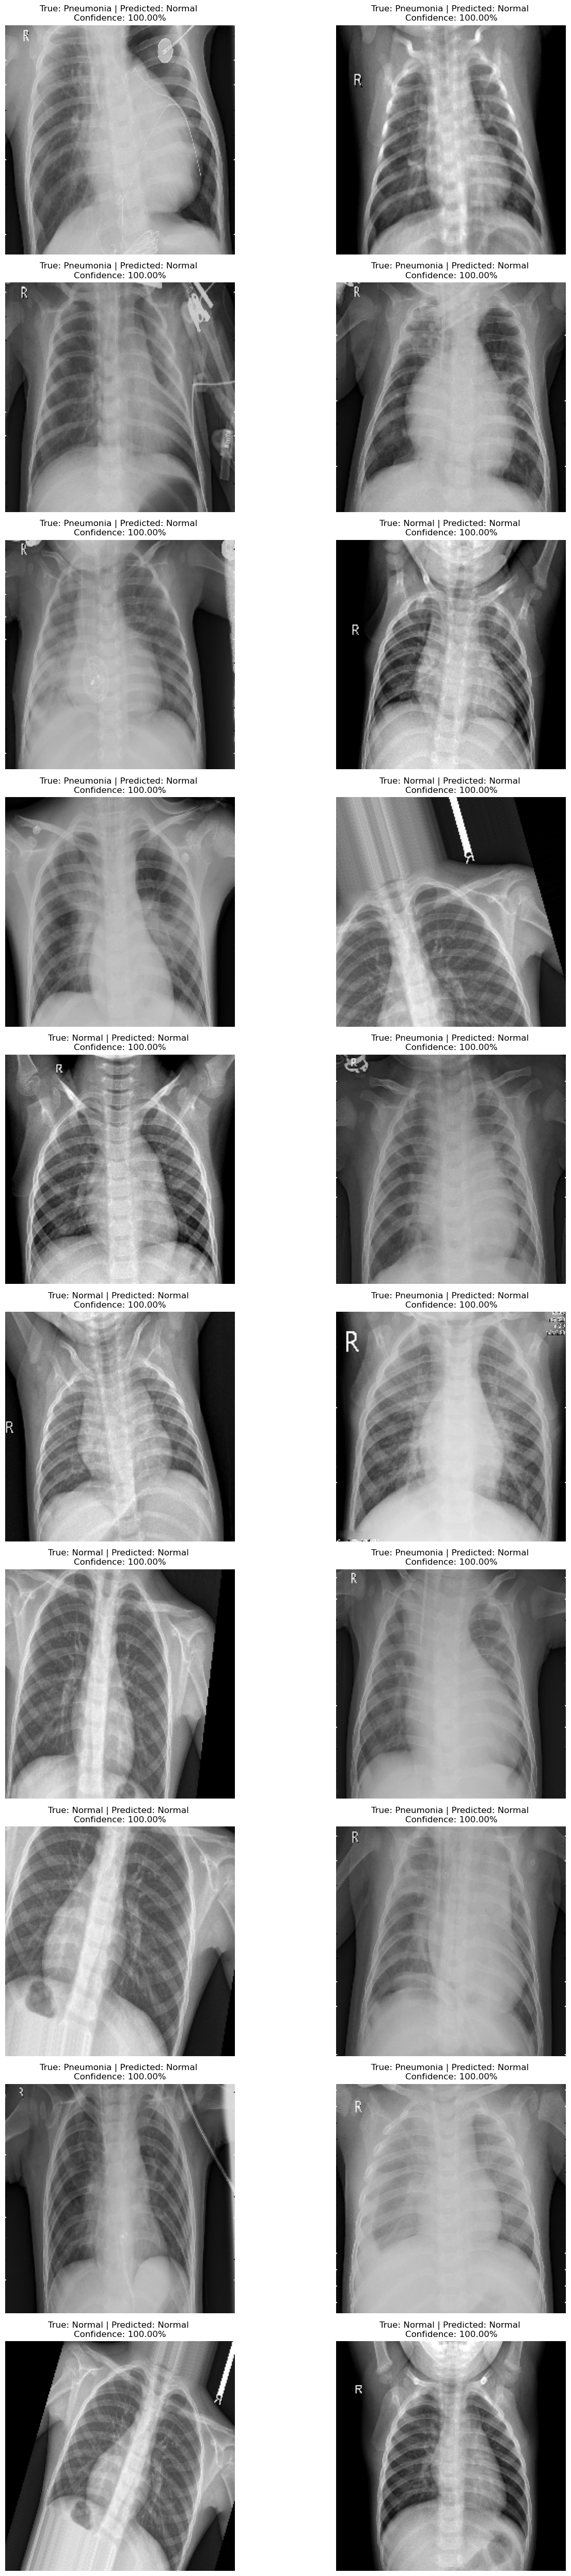

In [82]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Function to display random predictions with confidence scores (2 images per row)
def show_random_predictions_with_confidence(model, test_set, num_images=10, img_size=(224, 224)):  
    # Map class indices to labels
    class_labels = list(test_set.class_indices.keys())
    
    # Select random images from the test set
    random_indices = random.sample(range(len(test_set.filepaths)), num_images)
    selected_images = [test_set.filepaths[i] for i in random_indices]
    selected_labels = [test_set.labels[i] for i in random_indices]
    
    # Initialize figure for displaying results (2 images per row)
    rows = (num_images + 1) // 2  # Calculate number of rows needed
    plt.figure(figsize=(15, rows * 5))  # Adjust the height based on the number of rows
    
    for idx, img_path in enumerate(selected_images):
        # Load and preprocess the image
        img = load_img(img_path, target_size=img_size)  # Resize image to the desired size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make a prediction
        predictions = model.predict(img_array)
        predicted_label = class_labels[np.argmax(predictions)]
        true_label = class_labels[selected_labels[idx]]
        prediction_probs = predictions[0]  # Probabilities for each class
        
        # Display the image and prediction with probability in two columns per row
        plt.subplot(rows, 2, idx + 1)  # Arrange images in 2 columns per row
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {predicted_label} \nConfidence: {max(prediction_probs) * 100:.2f}%", fontsize=12)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# Call the function to display predictions with confidence
show_random_predictions_with_confidence(model, test, num_images=20, img_size=(224, 224))  # Change img_size to adjust image display size